## Часть 1
Напишите скрипт, который скачивает все данные с выборов губернатора СПб 2019г для всех избирательных участков. 

Входная точка [по ссылке](http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222). Затем нужно перейти на сайты территориальных избирательных комиссий. Результаты нужно сохранить в  `cvs`-файл, `sqlite` базе данных или `parquet`-файле. В итоге должна получиться таблица с полями:
- название ТИК (территориальная избирательная комиссия, некоторое объединение избирательных участков на определенной территории)
- номер УИК (избирательный участок)
- 14 стандартных полей из итогового протокола

Скрипт должен быть в отдельном `*.py` файле или в отдельном `jupyter`-ноутбуке. 

### Часть 2
Используя скаченные данные и `Pandas` (или `PySpark`) посчитайте:
- явку (%) по всем ТИК, результат отсортировать по убыванию
- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)
- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна
- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)
- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат
- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd


import requests
from bs4 import BeautifulSoup
import re

# Parser

In [84]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import math as m

In [78]:
def get_html(url):
    r = requests.get(url)
    return r

def extract_values(row):
    values = []
    row_values = row.find_all('td')
    for row_value in row_values:
        values.append(int(re.findall(r'\d+', row_value.text)[0]))
    return values

def parse(html,n_tik):    
    soup = BeautifulSoup(html.text, 'html.parser')
    table = soup.find_all('table')[-1]
    rows = table.find_all('tr')
    clear_rows = []
    for i, row in enumerate(rows):
        if i == 12:
            continue
        clear_rows.append(extract_values(row))
    data_tik = pd.DataFrame(data=clear_rows).transpose()
    data_tik['tik'] = [n_tik + 1 for _ in range (len(clear_rows[0]))]
    data_tik['uik'] = [clear_rows[0][i] for i in range(len(clear_rows[0]))]
    data_tik = data_tik[['tik', 'uik', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
    return data_tik

In [79]:
URL = 'http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222'
HOST = 'http://notelections.online'

In [80]:
html = get_html(URL)
soup = BeautifulSoup(html.text, 'html.parser')
links_in_html = soup.find_all('a', href=True)

good_links = []

for link in links_in_html:
    if link['href'].startswith('/region/region/st-petersburg') and link['href'].endswith('222'):
        good_links.append(HOST + link['href'])
        
del(links_in_html)

In [81]:
list_data_tik = []
for n_tik, link in enumerate(good_links):
    html_tik = get_html(link)
    list_data_tik.append(parse(html_tik,n_tik))

data = pd.concat(list_data_tik,axis=0)

In [82]:
data.index = [i for i in range(0, 2021)]
data = data.rename(columns = {12: 'Amosov', 13: 'Beglov', 14: 'Tihonova'})

In [83]:
data.head()

,tik,uik,1,2,3,4,5,6,7,8,9,10,11,Amosov,Beglov,Tihonova
0,1,1,1803,1200,587,11,602,11,587,23,575,0,0,110,345,120
1,1,2,1466,1100,433,14,653,14,430,19,425,0,0,53,326,46
2,1,3,2092,1600,576,22,1002,22,576,15,583,0,0,155,332,96
3,1,4,1056,1000,318,4,678,4,318,13,309,0,0,67,171,71
4,1,5,1827,1400,495,8,897,8,493,16,485,0,0,137,266,82


явка (%) по всем ТИК, результат отсортировать по убыванию

In [55]:
yavka_tik = []

for num_tik in range(1, 31):
    yavka_tik.append (((np.sum(data[data['tik'] == num_tik][3]) + (np.sum(data[data['tik'] == num_tik][4]))) / np.sum((data[data['tik'] == num_tik][1])) * 100, num_tik))

for tik in sorted(yavka_tik, reverse=True):
    print (f'Явка: {tik[0]:.2f} % ТИК: {tik[1]}')

Явка: 51.53 % ТИК: 18
Явка: 40.01 % ТИК: 15
Явка: 39.67 % ТИК: 13
Явка: 37.81 % ТИК: 19
Явка: 36.04 % ТИК: 8
Явка: 33.78 % ТИК: 20
Явка: 33.52 % ТИК: 9
Явка: 32.49 % ТИК: 22
Явка: 32.10 % ТИК: 30
Явка: 31.79 % ТИК: 2
Явка: 31.48 % ТИК: 1
Явка: 30.77 % ТИК: 29
Явка: 30.52 % ТИК: 10
Явка: 30.43 % ТИК: 4
Явка: 29.25 % ТИК: 7
Явка: 29.14 % ТИК: 21
Явка: 29.02 % ТИК: 25
Явка: 28.44 % ТИК: 17
Явка: 28.19 % ТИК: 23
Явка: 28.19 % ТИК: 16
Явка: 27.52 % ТИК: 14
Явка: 27.22 % ТИК: 28
Явка: 26.88 % ТИК: 11
Явка: 26.75 % ТИК: 5
Явка: 26.65 % ТИК: 24
Явка: 26.62 % ТИК: 3
Явка: 26.41 % ТИК: 12
Явка: 26.26 % ТИК: 26
Явка: 25.01 % ТИК: 6
Явка: 24.79 % ТИК: 27


выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат (%, учитывать участки на которых проголосовало больше 100 человек)

In [56]:
new_data = data[(data[3] + data[4]) > 100]

print('УИК № :',data.iloc[(new_data['Tihonova'] / (new_data[9])).idxmax()]['uik'])

УИК № : 2283


найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна

In [73]:
df = data.copy()

df['yavka'] = (df[3] + df[4]) / df[1]
df = df.groupby('tik')['yavka'].agg(min = 'min', max = 'max')
df['tik'] = [i for i in range(1, 31)]

print('ТИК: ', int(df.loc[(df['max'] - df['min']).idxmax()]['tik']))
print(df.loc[(df['max'] - df['min']).idxmax()])

ТИК:  17
min     0.17958
max     1.00000
tik    17.00000
Name: 17, dtype: float64


посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)

In [74]:
data['yavka'] = (data[3] + data[4]) / data[1]
data.groupby('tik')['yavka'].var().sort_values()

tik
25    0.000918
6     0.002066
14    0.003073
12    0.003322
7     0.007111
10    0.007409
3     0.007414
16    0.011347
9     0.011893
5     0.013662
20    0.017357
1     0.019318
19    0.020470
27    0.020633
26    0.021985
4     0.022281
18    0.023069
11    0.023945
29    0.024439
8     0.025984
24    0.027113
21    0.031019
17    0.032932
28    0.039207
13    0.039350
15    0.041609
22    0.045004
2     0.046018
30    0.052078
23    0.058670
Name: yavka, dtype: float64

для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат

In [94]:
data['Am'] = (100 * data['Amosov'] / data[9]).map(int)
data['Beg'] = (100 * data['Beglov'] / data[9]).map(int)
data['Tih'] = (100 * data['Tihonova'] / data[9]).map(int)

In [95]:
table_results = []
table_results.append(['Amosov', data[data.Am == 16].shape[0]])
table_results.append(['Beglov', data[data.Beg == 65].shape[0]])
table_results.append(['Tikhonova', data[data.Tih == 17].shape[0]])
table_results = pd.DataFrame(table_results)
table_results.columns = ['Candidate', 'num_of_uiks_with_final_result']

In [96]:
table_results

,Candidate,num_of_uiks_with_final_result
0,Amosov,148
1,Beglov,72
2,Tikhonova,192


визуализируйте отношение - явка на УИК  →  результат кандидата.

Text(0, 0.5, 'Результат Тихоновой %')

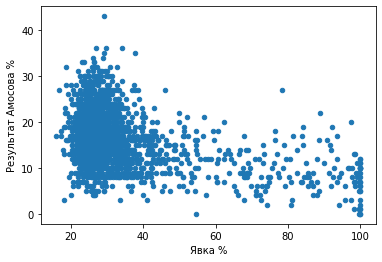

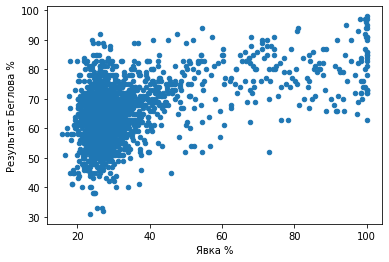

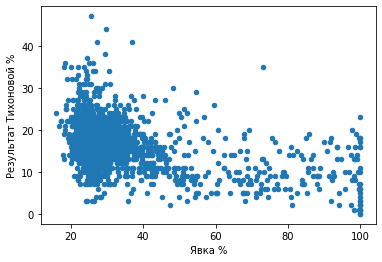

In [103]:
data['yavka'] = 100 * (data[3] + data[4]) / data[1]

ax = data.plot(x = 'yavka', y = 'Am', kind='scatter')
ax.set_xlabel('Явка %')
ax.set_ylabel('Результат Амосова %')

ax = data.plot(x = 'yavka', y = 'Beg', kind='scatter')
ax.set_xlabel('Явка %')
ax.set_ylabel('Результат Беглова %')

ax = data.plot(x = 'yavka', y = 'Tih', kind='scatter')
ax.set_xlabel('Явка %')
ax.set_ylabel('Результат Тихоновой %')